<a href="https://colab.research.google.com/github/aliebi/yes-no/blob/main/yes_no.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Tue Feb 16 08:44:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install torch torchvision
!pip install transformers
!pip install pandas
!pip install numpy

     |████████████████████████████████| 1.8MB 5.9MB/s 
     |████████████████████████████████| 890kB 54.6MB/s 
     |████████████████████████████████| 3.2MB 55.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=532aebac61751dd9edb846ca4b461da6bd934076c6f53a35825481742ad975c8
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [3]:
!gsutil cp gs://boolq/train.jsonl .
!gsutil cp gs://boolq/dev.jsonl .

Copying gs://boolq/train.jsonl...
/ [1 files][  6.2 MiB/  6.2 MiB]                                                
Operation completed over 1 objects/6.2 MiB.                                      
Copying gs://boolq/dev.jsonl...
/ [1 files][  2.1 MiB/  2.1 MiB]                                                
Operation completed over 1 objects/2.1 MiB.                                      


Read Hotpot Data

In [3]:
import pandas as pd

In [4]:
train = pd.read_csv('/content/drive/MyDrive/DFGN/train_select/paragraph_train_final.csv')
dev = pd.read_csv('/content/drive/MyDrive/DFGN/train_select/paragraph_dev_final.csv')

train = train.drop(['Unnamed: 0','Unnamed: 0.1'],axis = 1)
dev = dev.drop(['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1'],axis = 1)

In [40]:
train.head(5)

,index,id,question,title,answer,type,level,context,label
0,5,5a7a06935542990198eaf050,Which magazine was started first Arthur's Maga...,Arthur's Magazine,Arthur's Magazine,comparison,medium,Arthur's Magazine (1844–1846) was an American ...,True
1,7,5a7a06935542990198eaf050,Which magazine was started first Arthur's Maga...,First for Women,Arthur's Magazine,comparison,medium,First for Women is a woman's magazine publishe...,True
2,11,5a879ab05542996e4f30887e,The Oberoi family is part of a hotel company t...,Oberoi family,Delhi,bridge,medium,The Oberoi family is an Indian family that is ...,True
3,16,5a879ab05542996e4f30887e,The Oberoi family is part of a hotel company t...,The Oberoi Group,Delhi,bridge,medium,The Oberoi Group is a hotel company with its h...,True
4,23,5a8d7341554299441c6b9fe5,Musician and satirist Allie Goertz wrote a son...,Allie Goertz,President Richard Nixon,bridge,hard,"Allison Beth ""Allie"" Goertz (born March 2, 199...",True


In [5]:
def change_dataset(dataset1):
    list_of_rows = []
    for i in range(0, len(dataset1), 2):
        dictionary = {}

        # dictionary['question'] = dataset1.loc[i, 'question']
        if dataset1.loc[i, 'answer'] == 'yes':
          dictionary['answer'] = 1
        elif dataset1.loc[i, 'answer'] == 'no':
          dictionary['answer'] = 0
        else:
          dictionary['answer'] = dataset1.loc[i, 'answer']
        dictionary['context'] = dataset1.loc[i, 'context']+" " + dataset1.loc[i + 1, 'context']
        dictionary['question'] = dataset1.loc[i, 'question']


        list_of_rows.append(dictionary)

    return pd.DataFrame(list_of_rows)


train = change_dataset(train)
dev = change_dataset(dev)


In [6]:
train = train.loc[train['answer'].isin([1,0])]
dev = dev.loc[dev['answer'].isin([1,0])]

In [43]:
train.head(20)

,answer,context,question
27,0,Leonid Anatolievich Levin ( ; Russian: Леони́д...,Were Pavel Urysohn and Leonid Levin known for ...
28,0,Kings of Leon is an American rock band that fo...,Are both The New Pornographers and Kings of Le...
32,1,First for Women is a woman's magazine publishe...,Are Jane and First for Women both women's maga...
49,0,"The paloma (Spanish for ""dove"") is a tequila-b...",Are Gin and tonic and Paloma both cocktails ba...
67,1,"Timothy James ""Tim"" McIlrath (born November 3,...",Are both Tim McIlrath and Spike Slawson Americ...
87,1,"Pamela Renea Veasey (born May 25, 1962) is an ...",Are Pam Veasey and Jon Jost both American?
89,1,The Augusta Canal is a historic canal located ...,Are the New Orleans Outfall Canals the same le...
103,1,Wenling (Wenling dialect: Uen-lin Zy ] ; ) is ...,Are Wenling and Xinzheng both in China?
128,1,"The Singer Building or Singer Tower, at Libert...",Are Manhattan West and Singer Building both pr...
137,0,"Robert Fleischman (born March 11, 1953) is an ...",Do musicians Robert Fleischman and Jimmy Barne...


In [7]:
import random
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set seeds for reproducibility
random.seed(26)
np.random.seed(26)
torch.manual_seed(26)

tokenizer = AutoTokenizer.from_pretrained("roberta-large") 
# google/electra-large-discriminator
model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/yes-no-longformer/BoolQ-models2")
model.to(device) # Send the model to the GPU if we have one

learning_rate = 1e-5
optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8)

In [21]:
def encode_data(tokenizer, questions, passages, max_length):
    """Encode the question/passage pairs into features than can be fed to the model."""
    input_ids = []
    attention_masks = []

    for question, passage in zip(questions, passages):
        encoded_data = tokenizer.encode_plus(question, passage, max_length=max_length, pad_to_max_length=True, truncation_strategy="longest_first")
        encoded_pair = encoded_data["input_ids"]
        attention_mask = encoded_data["attention_mask"]

        input_ids.append(encoded_pair)
        attention_masks.append(attention_mask)

    return np.array(input_ids), np.array(attention_masks)

# Loading data
# train_data_df = pd.read_json("/content/train.jsonl", lines=True, orient='records')
# dev_data_df = pd.read_json("/content/dev.jsonl", lines=True, orient="records")

passages_train = train.context.values
questions_train = train.question.values
answers_train = train.answer.values.astype(int)

passages_dev = dev.context.values
questions_dev = dev.question.values
answers_dev = dev.answer.values.astype(int)

# Encoding data
max_seq_length = 512
input_ids_train, attention_masks_train = encode_data(tokenizer, questions_train, passages_train, max_seq_length)
input_ids_dev, attention_masks_dev = encode_data(tokenizer, questions_dev, passages_dev, max_seq_length)

train_features = (input_ids_train, attention_masks_train, answers_train)
dev_features = (input_ids_dev, attention_masks_dev, answers_dev)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [22]:
# Building Dataloaders
batch_size = 1

train_features_tensors = [torch.tensor(feature, dtype=torch.long) for feature in train_features]
dev_features_tensors = [torch.tensor(feature, dtype=torch.long) for feature in dev_features]

train_dataset = TensorDataset(*train_features_tensors)
dev_dataset = TensorDataset(*dev_features_tensors)

train_sampler = RandomSampler(train_dataset)
dev_sampler = SequentialSampler(dev_dataset)

train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)
dev_dataloader = DataLoader(dev_dataset, sampler=dev_sampler, batch_size=batch_size)

In [23]:
epochs = 6
grad_acc_steps = 4
train_loss_values = []
dev_acc_values = []

cnt = 3
for _ in tqdm(range(epochs), desc="Epoch"):

  # Training
  epoch_train_loss = 0 # Cumulative loss
  model.train()
  model.zero_grad()

  for step, batch in tqdm(enumerate(train_dataloader)):

      input_ids = batch[0].to(device)
      attention_masks = batch[1].to(device)
      labels = batch[2].to(device)     

      outputs = model(input_ids, token_type_ids=None, attention_mask=attention_masks, labels=labels)

      loss = outputs[0]
      loss = loss / grad_acc_steps
      epoch_train_loss += loss.item()

      loss.backward()
      
      if (step+1) % grad_acc_steps == 0: # Gradient accumulation is over
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Clipping gradients
        optimizer.step()
        model.zero_grad()

  epoch_train_loss = epoch_train_loss / len(train_dataloader)          
  train_loss_values.append(epoch_train_loss)
  
  # Evaluation
  epoch_dev_accuracy = 0 # Cumulative accuracy
  model.save_pretrained("/content/drive/MyDrive/yes-no-longformer/hotpot-modelsplus{}".format(cnt))
  cnt +=1
  model.eval()

  for batch in dev_dataloader:
    
    input_ids = batch[0].to(device)
    attention_masks = batch[1].to(device)
    labels = batch[2]
                
    with torch.no_grad():        
        outputs = model(input_ids, token_type_ids=None, attention_mask=attention_masks)
                    
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    
    predictions = np.argmax(logits, axis=1).flatten()
    labels = labels.numpy().flatten()
    
    epoch_dev_accuracy += np.sum(predictions == labels) / len(labels)

  epoch_dev_accuracy = epoch_dev_accuracy / len(dev_dataloader)
  dev_acc_values.append(epoch_dev_accuracy)

Streaming output truncated to the last 5000 lines.
483it [01:46,  4.79it/s]
484it [01:46,  3.97it/s]
485it [01:47,  4.69it/s]
486it [01:47,  4.74it/s]
487it [01:47,  4.78it/s]
488it [01:47,  3.97it/s]
489it [01:47,  4.71it/s]
490it [01:48,  4.76it/s]
491it [01:48,  4.79it/s]
492it [01:48,  3.97it/s]
493it [01:48,  4.71it/s]
494it [01:49,  4.76it/s]
495it [01:49,  4.79it/s]
496it [01:49,  3.98it/s]
497it [01:49,  4.71it/s]
498it [01:49,  4.76it/s]
499it [01:50,  4.79it/s]
500it [01:50,  3.98it/s]
501it [01:50,  4.71it/s]
502it [01:50,  4.75it/s]
503it [01:51,  4.79it/s]
504it [01:51,  3.97it/s]
505it [01:51,  4.70it/s]
506it [01:51,  4.75it/s]
507it [01:51,  4.79it/s]
508it [01:52,  3.93it/s]
509it [01:52,  4.66it/s]
510it [01:52,  4.72it/s]
511it [01:52,  4.76it/s]
512it [01:53,  3.96it/s]
513it [01:53,  4.69it/s]
514it [01:53,  4.74it/s]
515it [01:53,  4.78it/s]
516it [01:54,  3.97it/s]
517it [01:54,  4.70it/s]
518it [01:54,  4.75it/s]
519it [01:54,  4.79it/s]
520it [01:54,  3.97it/s]

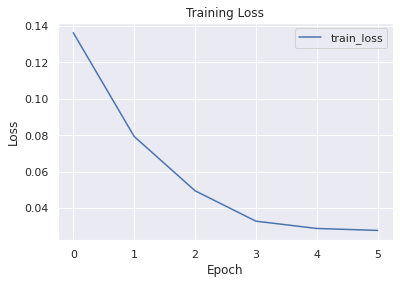

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

plt.plot(train_loss_values, label="train_loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.xticks(np.arange(0, 6))
plt.show()

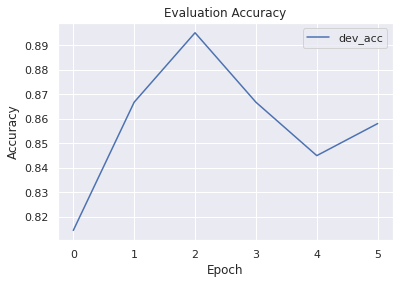

In [25]:

plt.plot(dev_acc_values, label="dev_acc")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Evaluation Accuracy")
plt.legend()
plt.xticks(np.arange(0, 6))
plt.show()

In [ ]:
def predict(question, passage):
  sequence = tokenizer.encode_plus(question, passage, return_tensors="pt")['input_ids'].to(device)
  
  logits = model(sequence)[0]
  probabilities = torch.softmax(logits, dim=1).detach().cpu().tolist()[0]
  proba_yes = round(probabilities[1], 2)
  proba_no = round(probabilities[0], 2)

  print(f"Question: {question}, Yes: {proba_yes}, No: {proba_no}")
  
passage_superbowl = """Super Bowl 50 was an American football game to determine the champion of the National Football League
                    (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated
                    the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title.
                    The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at Santa Clara,
                    California. As this was the 50th Super Bowl, the league emphasized the 'golden anniversary' with various
                    gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game
                    with Roman numerals (under which the game would have been known as 'Super Bowl L'), so that the logo could
                    prominently feature the Arabic numerals 50."""
 
passage_illuin = """Illuin designs and builds solutions tailored to your strategic needs using Artificial Intelligence
                  and the new means of human interaction this technology enables."""

superbowl_questions = [
"Did the Denver Broncos win the Super Bowl 50?", 
"Did the Carolina Panthers win the Super Bowl 50?",
"Was the Super Bowl played at Levi's Stadium?", 
"Was the Super Bowl 50 played in Las Vegas?", 
"Was the Super Bowl 50 played in February?", 
"Was the Super Bowl 50 played in March?"
]

question_illuin = "Is Illuin the answer to your strategic needs?"

for s_question in superbowl_questions:
  predict(s_question, passage_superbowl)

predict(question_illuin, passage_illuin)